**STATISTICAL LEARNING AND NEURAL NETWORKS, A.A. 2022/2023**

**COMPUTER LAB 3** - Principal component analysis

**Duration: 3 hours**

**Introduction:**

Hyperspectral images are scientific images of the Earth, acquired by satellites or aicrafts; rather than having three R/G/B color channels, these images have a lot more “color” components obtained through a fine sampling of the wavelength (hence the name “hyper”-spectral). The 
resulting 3-dimensional dataset has one image (spectral band or “color”) for every sampled wavelength, which represents the measured radiance from each pixel at that specific wavelength. Hyperspectral images are very useful for image analysis. For every pixel at a given spatial position, it is possible to extract a so-called spectral vector, i.e. the 1-dimensional vector of values assumed by that pixel at all wavelengths. Assuming that each pixel is composed of just one substance, the spectral vector represents the radiance of that substance at all the wavelengths that have been 
sampled. Spectral vectors, therefore, can be used to infer which substance is contained in a given pixel – a typical classification problem that has a lot of practical applications in agriculture, analysis of land use / land cover, and other applications related to the study of the environment.


In this lab you will use a real hyperspectral image that has been acquired by the AVIRIS instrument, an airborne hyperspectral imager operated by the NASA. The image represents a scene of Indian Pines (Indiana, USA). It has a size of 145x145 pixels and 220 spectral bands. Along with the image, a ground truth is available, in terms of labels specifying which class (out of 16) each pixel belongs to. The classes are reported below; for more information, please see 
http://www.ehu.eus/ccwintco/index.php/Hyperspectral_Remote_Sensing_Scenes#Indian_Pines

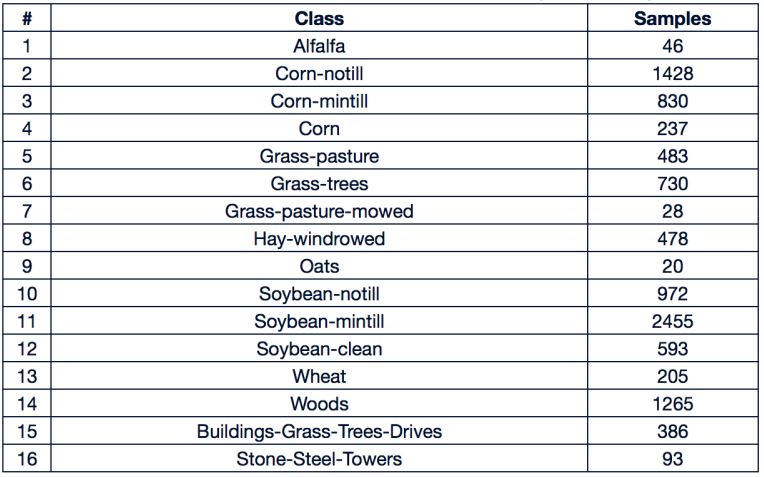

The purpose of this computer lab is twofold:
To apply PCA to the spectral vectors in order to reduce their dimensionality.

*   To apply PCA to the spectral vectors in order to reduce their dimensionality.
*   To perform classification on the reduced data (optional)

**Exercise 1 – PCA**


In this exercise, you will employ the Indian Pines dataset. You will not do this for the entire dataset, but only for the spectral vectors belonging to **two classes** (as in the optional exercise you will perform 2-class classification on the PCA coefficients). 

**Reminder:** the input to the PCA must always have zero mean: besides the sample covariance, you will have to compute the **mean value μ** over the training set and subtract it from each test vector before applying PCA.

**Task:** You have to reduce the dimensionality of the spectral vectors of the two classes you have chosen using PCA. In particular, you should perform the following:


*   Extract spectral vectors of two classes, as described above.
*   Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)
*   Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matric containing the eigenvalues on the main diagonal.
  * Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them by yourself.
*   Choose a number of dimensions K<=220.
*   Construct the eigenvector matrix W for K components (i.e., select the last K columns)
*   Using W, compute the PCA coefficients for each spectral vector in the data set
*   Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)
*   Plot the average MSE over the test set as a function of K.
*   Plot the eigenvectors corresponding to the 3 largest eigenvalues – this will give you an idea of the basis functions employed by PCA

In [1]:
import numpy as np
import h5py
import scipy.io
import matplotlib.pyplot as plt

mat = scipy.io.loadmat(r"Indian_pines.mat")
indian_pines = np.array(mat['indian_pines']) 

mat = scipy.io.loadmat(r"Indian_pines_gt.mat")
indian_pines_gt = np.array(mat['indian_pines_gt'])

In [2]:
print(indian_pines.shape)
print(indian_pines[0,0,:].shape)
#we have 145 x 145 data points (pixels)
#each is a 2d point (above (0,0)) that has 220 features (radiance for each length)
#indian_pines_gt[i,j] is the class label of pixel (i,j)

(145, 145, 220)
(220,)


**Extract spectral vectors of two classes**

In [3]:
# We consider 2 classes that have roughly the same sample size
class1_value = 14
class2_value = 2
class1=np.zeros((1500,220))
class2=np.zeros((1500,220))
n=0
for i in range(145):
    for j in range(145):
        if indian_pines_gt[i,j]== class1_value:
            class1[n,:] = indian_pines[i,j,:]/1.
            n+=1
class1=class1[:n,:]
# Sample size for class 14
print(n)
n=0
for i in range(145):
    for j in range(145):
        if indian_pines_gt[i,j]== class2_value:
            class2[n,:] = indian_pines[i,j,:]/1.
            n+=1
class2=class2[:n,:]
# Sample size for class 2
print(n)


1265
1428


**Estimate the sample covariance matrix of the dataset as a whole (i.e., considering together spectral vectors of the two classes)**

In [3]:
def samplematcov(data):
    n = len(data[0,:])
    tot=len(data)
    μ = np.zeros(n)
    Σ = [[  0.0 for _ in range(n)] for _ in range(n)]
    for datapt in data[:,range(n)]:
        for j in range(n):
            μ[j] += (1/tot)*(datapt[j]) 
    data =data - μ  # remove mean
    for datapt in data[:,range(n)]:
        Σ += (1/tot)*np.matmul(datapt[:,np.newaxis],datapt[np.newaxis,:])
    return μ,Σ

In [6]:
train_data = np.append(class1,class2,axis=0)
μ, Σ = samplematcov(train_data)

**Perform the eigenvector decomposition of the sample covariance matrix. You can use the numpy linalg.eig function, which outputs the matrix containing the eigenvectors as columns, and a diagonal matrix containing the eigenvalues on the main diagonal.**

In [13]:
from numpy import linalg as LA

In [7]:
w, v = LA.eig(Σ)
#Note: in the output matrix, eigenvectors/eigenvalues are not necessarily ordered by eigenvalue magnitude. You should sort them first.

In [8]:
# the eigenvalue w[j] corresponds to the eigenvector v[:,j]
K =  220
wsortK = np.argsort(w, axis=0)[::-1][:K]
# wsortK returns the indices of the K biggest eigenvalues
# from which we can obtain the corresponding eigenvectors
W = v[:,wsortK]
# in W we have the K eigeinvectors of Σ relative to the 
# K biggest eigenvalues (disposed by column)

**Using W, compute the PCA coefficients for each spectral vector in the data set. Then from the PCA coefficients obtain an approximation of the corresponding vector and compute the error (mean square error - MSE)**

In [4]:
def PCA(eigenval,eigenvec,data,K):
    """
    Input: Eingevalues and eigenvector of the sample covariance matrix computed on data, K is the dimension of the PCA coefficients.
    Output: PCA coefficients, approximation of data using PCA coefficients and corresponding MSE.
    
    """
    N=len(data)
    T=len(data[0,:])
    μ = np.zeros(T)
    for datapt in data[:,range(T)]:
        for j in range(T):
            μ[j] += (1/N)*(datapt[j]) 
    data =data - μ  # zero mean
    MSE=0.0
    z = [[  0.0 for _ in range(K)] for _ in range(N)]
    xpred = [[  0.0 for _ in range(T)] for _ in range(N)]
    eigenvsortK = np.argsort(eigenval, axis=0)[::-1][:K]
    W=eigenvec[:,eigenvsortK]
    WT= np.transpose(W)
    for j in range(N):
        z[j]=np.matmul(WT,data[j,:][:,np.newaxis])
        xpred[j]=np.matmul(W,z[j])
        MSE+=(1/N)*np.matmul(np.transpose(xpred[j]-data[j,:][:,np.newaxis]),xpred[j]-data[j,:][:,np.newaxis])        
    return MSE,z,xpred
    

**Computing MSE**

In [ ]:
rnge=np.arange(5,221,5)
MSE=[0.0 for _ in rnge]
i=0
for K in rnge:
    MSE[i],z ,xpred= PCA(w,v,train_data,K)
    MSE[i]=float(MSE[i])
    i+=1

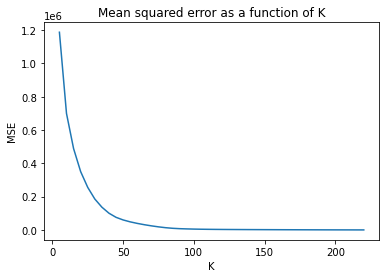

In [13]:
plt.figure()
plt.plot(rnge,MSE)
plt.title('Mean squared error as a function of K')
plt.xlabel('K')
plt.ylabel('MSE')
plt.show()

**Plot of the 3 eigenvectors with the biggest eigenvalues**

In [14]:
eigenvec=[W[:,0],W[:,1],W[:,2]]
K_range=np.arange(1,221,1)

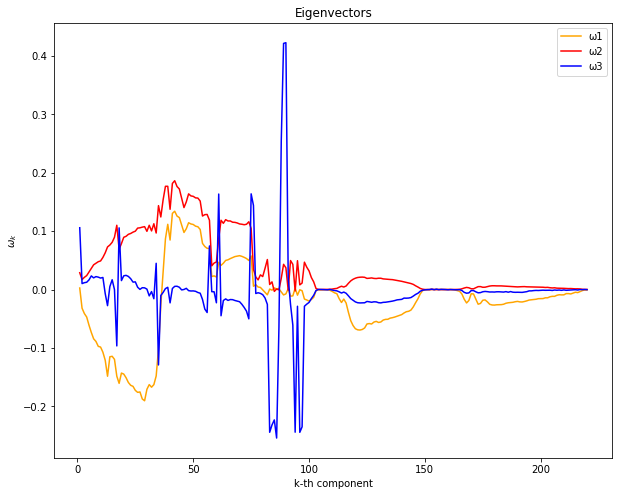

In [15]:
plt.figure(2,(10,8))
plt.plot(K_range,eigenvec[0],label = 'ω1',color = "orange")
plt.plot(K_range,eigenvec[1],label = 'ω2',color = "red")
plt.plot(K_range,eigenvec[2],label = 'ω3',color = "blue")
plt.title('Eigenvectors')
plt.xlabel('k-th component')
plt.ylabel('$ω_{k}$')
plt.legend()
plt.show()

**Comments to Exercise 1**


PCA was implemented to reduce the features dimensionality of our dataset from 220 to a new dataset of $K$ uncorrelated significant features (principal components). The above figure (MSE as a function of $K$) shows that the increase of principal components in the newly produced dataset increases accuracy of the classifier. After taking the first 100 components the MSE of the classifier becomes constant and doesn’t show significant improvement for additional components. Hence, choosing only first $K$ components will be enough to reconstruct the dataset that satisfy the sample properties.